# InterestBasic

Author: Sha Yuan (2018), Yuteng Huang (2025)

## Preparation

Install the packages:

```
pip install pandas numpy scikit-learn gensim keras nltk tensorflow matplotlib
```

Ensure your directory structure:

```
/
- this_notebook.ipynb
- /data/
  - labels.txt
  - papers.txt
  - training.txt
  - validation.txt
```


In [1]:
MAX_TRAIN_SAMPLES = 3000

# Preprocessing
with open("data/training.txt", "r", encoding="utf-8") as f:
    # Reads the file and stores strings (which is separated by '\n') into a list
    train = [s.strip() for s in f.readlines()]
    # Filters the empty string which is the empty rows in train.txt
    train = list(filter(lambda s: s, train))
    # Limits the number of training samples
    train = train[:min(MAX_TRAIN_SAMPLES, len(train))]

print(f"Number of training samples: {len(train)}", )
print(f"First lines:\n{train[:5]}")

Number of training samples: 3000
First lines:
['Daniel J. Paulish', 'software engineering,software architecture,software design', 'José Cristóbal Riquelme Santos', 'neural networks,machine learning,evolutionary algorithm', 'Fernando C. N. Pereira']


In [2]:
import pandas as pd

authors = []
labels1 = []
labels2 = []
labels3 = []
for idx, item in enumerate(train):
    if idx % 2 == 0:
        authors.append(item)
    else:
        item = item.split(",")
        labels1.append(item[0])
        labels2.append(item[1])
        labels3.append(item[2])

dfTrain = pd.DataFrame(
    {
        "author": authors,
        "Interest1": labels1,
        "Interest2": labels2,
        "Interest3": labels3,
    }
)
del authors, labels1, labels2, labels3
print(f"First authors:\n{dfTrain[:5]}")

First authors:
                           author              Interest1  \
0               Daniel J. Paulish   software engineering   
1  José Cristóbal Riquelme Santos        neural networks   
2          Fernando C. N. Pereira       computer science   
3                    Juan de Lara       computer science   
4                 Stefano Lonardi  computational biology   

                     Interest2               Interest3  
0        software architecture         software design  
1             machine learning  evolutionary algorithm  
2  natural language processing      speech recognition  
3         software engineering          model checking  
4               bioinformatics             data mining  


In [3]:
with open("data/validation.txt", "r") as f:
    validation = f.read().split("\n")
    # validation = list(filter(lambda s: s, validation))
    dfTest = pd.DataFrame(validation)
    del validation

    dfTest.columns = ["author"]
    dfTotal = pd.concat([dfTrain, dfTest], axis=0).fillna("")
    dfTotal.index = dfTotal["author"]

print(dfTotal[-5:])

                              author Interest1 Interest2 Interest3
author                                                            
Pim van den Broek  Pim van den Broek                              
                                                                  
Christof Hasse        Christof Hasse                              
                                                                  
                                                                  


In [4]:
# 读取papers.txt，将其转换成pandas的DataFrame格式
MAX_PAPERS = 3000
papers = []
with open("data/papers.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        if line.startswith("#index"):
            paper_info = {}
            papers.append(paper_info)
            paper_info["index"] = line[6:].strip()
            paper_info["citation"] = ""
        elif line.startswith("#@"):
            paper_info["author"] = line[2:].strip()
        elif line.startswith("#*"):
            paper_info["paper"] = line[2:].strip()
        elif line.startswith("#t"):
            paper_info["year"] = line[2:].strip()
        elif line.startswith("#c"):
            paper_info["journal"] = line[2:].strip()
        elif line.startswith("#%"):
            paper_info["citation"] = paper_info["citation"] + line[2:] + ","

        if len(papers) >= MAX_PAPERS:
            break

print(f"Number of papers loaded: {len(papers)}")
dfPapers = pd.DataFrame(papers)
dfPapers.index = dfPapers["index"]
dfPapers = dfPapers.dropna()
del papers

print(dfPapers[:5])

Number of papers loaded: 3000
      index                                           citation  \
index                                                            
0         0                                                      
1         1  1775098\n,1648782\n,2206608\n,2857290\n,267443...   
2         2                                                      
3         3                                           96303\n,   
4         4                                                      

                                                  author  \
index                                                      
0                          Sinjini Mitra,Marios Savvides   
1      Alberto Villa,Jocelyn Chanussot,Jon Atli Bened...   
2            Tingyuan Nie,Tomoo Kisaka,Masahiko Toyonaga   
3                                Yilmaz Erdem,Ümit Totur   
4      Sid-Ahmed Boukabara,Kevin Garrett,Wanchun Chen...   

                                                   paper  year  \
index               

In [5]:
"""
处理机构名和文章标题，方便做tfidf
处理方法包括：删除标点符号，统一大小写
"""


def removeSpace(x):
    new_x = ""
    for i in x.split(" "):
        new_x += i
    return new_x


"""
将期刊名+期刊名作为一个单词+论文标题组成一篇文档
例如：期刊名为Computer Vision, 论文标题为convolution neural networks
则生成文档为: Computer Vision convolution neural networks Computer_Vision
"""
# pd.set_option('display.max_rows',500)
# pd.set_option('display.max_columns',500)
# pd.set_option('display.width',1000)

dfPapers["jour_"] = dfPapers["journal"].apply(removeSpace)
dfPapers["jour_paper"] = (
    dfPapers["journal"] + " " + dfPapers["paper"] + dfPapers["jour_"]
)
jour_list = list(dfPapers["jour_"].unique())
dfPapers.drop("jour_", axis=1, inplace=True)
print(dfPapers.loc[["0", "1", "2"], ["jour_paper"]])
print(list(dfPapers.loc["1", ["jour_paper"]]))

                                              jour_paper
index                                                   
0      ICASSP (2) Improved Human Face Identification ...
1      Pattern Recognition Unsupervised methods for t...
2      ISCAS (6) A post layout watermarking method fo...
['Pattern Recognition Unsupervised methods for the classification of hyperspectral images with low spatial resolution.PatternRecognition']


In [6]:
def normalize_text(text):
    norm_text = text.lower()
    norm_text = norm_text.replace("<br />", " ")
    for char in [".", '"', ",", "(", ")", "!", "?", ":", ";", "-"]:
        norm_text = norm_text.replace(char, " " + char + " ")
    return norm_text


dfPapers["jour_paper"] = dfPapers["jour_paper"].apply(normalize_text)
docs = list(dfPapers["jour_paper"].values)
print(docs[:10])

['icassp  ( 2 )  improved human face identification using frequency domain representation of facial asymmetry . icassp ( 2 ) ', 'pattern recognition unsupervised methods for the classification of hyperspectral images with low spatial resolution . patternrecognition', 'iscas  ( 6 )  a post layout watermarking method for ip protection . iscas ( 6 ) ', 'computers & mathematics with applications some tauberian theorems for the product method of borel and cesàro summability . computers&mathematicswithapplications', 'ieee t .  geoscience and remote sensing mirs :  an all - weather 1dvar satellite data assimilation and retrieval system . ieeet . geoscienceandremotesensing', 'journal of approximation theory convergence rates of vector cascade algorithms in lp . journalofapproximationtheory', 'i .  j .  medical informatics desirability and expectations of the uk ms register :  views of people with ms . i . j . medicalinformatics', 'icisc fractional windows revisited :  improved signed - digit r

In [7]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r"\w+")
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()
    docs[idx] = tokenizer.tokenize(docs[idx])
print(docs[:50])

[['icassp', '2', 'improved', 'human', 'face', 'identification', 'using', 'frequency', 'domain', 'representation', 'of', 'facial', 'asymmetry', 'icassp', '2'], ['pattern', 'recognition', 'unsupervised', 'methods', 'for', 'the', 'classification', 'of', 'hyperspectral', 'images', 'with', 'low', 'spatial', 'resolution', 'patternrecognition'], ['iscas', '6', 'a', 'post', 'layout', 'watermarking', 'method', 'for', 'ip', 'protection', 'iscas', '6'], ['computers', 'mathematics', 'with', 'applications', 'some', 'tauberian', 'theorems', 'for', 'the', 'product', 'method', 'of', 'borel', 'and', 'cesàro', 'summability', 'computers', 'mathematicswithapplications'], ['ieee', 't', 'geoscience', 'and', 'remote', 'sensing', 'mirs', 'an', 'all', 'weather', '1dvar', 'satellite', 'data', 'assimilation', 'and', 'retrieval', 'system', 'ieeet', 'geoscienceandremotesensing'], ['journal', 'of', 'approximation', 'theory', 'convergence', 'rates', 'of', 'vector', 'cascade', 'algorithms', 'in', 'lp', 'journalofappr

In [8]:
# Remove numbers
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

print(docs[:50])

[['icassp', 'improved', 'human', 'face', 'identification', 'using', 'frequency', 'domain', 'representation', 'of', 'facial', 'asymmetry', 'icassp'], ['pattern', 'recognition', 'unsupervised', 'methods', 'for', 'the', 'classification', 'of', 'hyperspectral', 'images', 'with', 'low', 'spatial', 'resolution', 'patternrecognition'], ['iscas', 'post', 'layout', 'watermarking', 'method', 'for', 'ip', 'protection', 'iscas'], ['computers', 'mathematics', 'with', 'applications', 'some', 'tauberian', 'theorems', 'for', 'the', 'product', 'method', 'of', 'borel', 'and', 'cesàro', 'summability', 'computers', 'mathematicswithapplications'], ['ieee', 'geoscience', 'and', 'remote', 'sensing', 'mirs', 'an', 'all', 'weather', '1dvar', 'satellite', 'data', 'assimilation', 'and', 'retrieval', 'system', 'ieeet', 'geoscienceandremotesensing'], ['journal', 'of', 'approximation', 'theory', 'convergence', 'rates', 'of', 'vector', 'cascade', 'algorithms', 'in', 'lp', 'journalofapproximationtheory'], ['medical',

In [9]:
# get word_list
def processDoc(docs):
    wordList = {}
    for doc in docs:
        for word in doc:
            if word not in wordList.keys():
                wordList[word] = 1
            else:
                wordList[word] += 1
    return wordList


# 删去一些可能无用的词
wordList = processDoc(docs)
word_ind = list(wordList.keys())
word_val = list(wordList.values())
wordList = pd.DataFrame(word_val)
wordList.index = word_ind
# print(wordList[:100])
# 取出现次数超过20的词加入到tfidf 的计算中
wordList = list(wordList[wordList[0] > 20].index)
print(wordList)

['icassp', 'improved', 'human', 'identification', 'using', 'frequency', 'domain', 'representation', 'of', 'pattern', 'recognition', 'methods', 'for', 'the', 'classification', 'images', 'with', 'low', 'spatial', 'iscas', 'method', 'computers', 'mathematics', 'applications', 'and', 'ieee', 'sensing', 'an', 'data', 'retrieval', 'system', 'journal', 'theory', 'vector', 'algorithms', 'in', 'efficient', 'transactions', 'security', 'multi', 'user', 'model', 'systems', 'on', 'computer', 'networks', 'dynamic', 'globecom', 'network', 'analysis', 'approach', 'to', 'problem', 'feedback', 'control', 'nonlinear', 'from', 'icip', 'study', 'cloud', 'sensor', 'by', 'int', 'information', 'comput', 'syst', 'sci', 'new', 'science', 'trans', 'med', 'imaging', 'ieeetrans', 'interspeech', 'high', 'multiple', 'at', 'visual', 'signal', 'processing', 'optimal', 'design', 'circuits', 'video', 'rate', 'based', 'iros', 'robust', 'models', 'level', 'support', 'via', 'generation', 'neural', 'learning', 'time', 'acm'

In [10]:
stop_word = ["and", "a", "an", "by", "of", "on", "to", "with", "for", "the", "in", "or"]
wordList.extend(jour_list)
for word in stop_word:
    if word in wordList:
        wordList.remove(word)
wordList = set(wordList)

for idx, doc in enumerate(docs):
    new_doc = []
    for word in doc:
        if word in wordList:
            new_doc.append(word)
    docs[idx] = " ".join(new_doc)
print(docs[:100])

['icassp improved human identification using frequency domain representation icassp', 'pattern recognition methods classification images low spatial', 'iscas method iscas', 'computers mathematics applications method computers', 'ieee sensing data retrieval system', 'journal theory vector algorithms', '', 'improved efficient', 'transactions security multi user', 'model human', 'systems data computer networks', 'dynamic', 'globecom networks globecom', 'network analysis approach human problem', '', 'feedback control nonlinear systems', '', 'from', 'icip study cloud images icip', 'ieee sensor', '', 'int information information', 'ieee transactions', '', 'comput syst sci new comput syst sci', 'methods computer science systems', 'using theory model', 'ieee trans med imaging method images ieeetrans med imaging', 'interspeech using high recognition multiple recognition systems interspeech', '', 'at', 'recognition', 'visual recognition using', 'signal processing optimal design', 'ieee trans cir

In [11]:
# 做TFIDF 转换
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(docs))
print(type(tfidf))
print(tfidf)
# print(tfidf.shape) # (3053717, 34821) 行数为文档编号，列数为单词编号

<class 'scipy.sparse._csr.csr_matrix'>
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10602 stored elements and shape (2979, 238)>
  Coords	Values
  (0, 57)	0.31182748854863745
  (0, 77)	0.3234267785759964
  (0, 91)	0.28709044060984884
  (0, 92)	0.6117936675422633
  (0, 97)	0.31848606695300385
  (0, 105)	0.3209002589620856
  (0, 178)	0.31848606695300385
  (0, 229)	0.1886865063079824
  (1, 27)	0.3808552587350276
  (1, 102)	0.3887553217555127
  (1, 128)	0.3808552587350276
  (1, 138)	0.35995620630440367
  (1, 163)	0.3790102885591311
  (1, 177)	0.33848599455585493
  (1, 206)	0.4134946260755
  (2, 117)	0.9349977108067218
  (2, 137)	0.3546537477402288
  (3, 11)	0.3631393358579969
  (3, 40)	0.7622026683661884
  (3, 133)	0.38669559924435426
  (3, 137)	0.37100327304907255
  (4, 46)	0.3847385039976021
  (4, 98)	0.3469051908712006
  (4, 180)	0.5198317621121266
  (4, 194)	0.5611763647447693
  :	:
  (2971, 29)	0.6823029113400618
  (2971, 33)	0.5971282795713324
  (2971, 98)	0.42178259

In [12]:
import numpy as np

# 获取每个作者发表的文章
dfPapers.index = np.arange(len(dfPapers))
dfPapers["index"] = dfPapers.index
dfPapers["index"] = dfPapers.index.astype(str)

# get cited numbers
cited = []  # cited numbers
for _ in dfPapers.index:
    cited.append("")

# print(type(dfPapers.index)) # <class 'pandas.core.indexes.numeric.Int64Index'>
# print(type(dfPapers['index'])) # <class 'pandas.core.series.Series'>

# cite = dfPapers.loc[1,['citation']]
# print(type(cite)) #<class 'pandas.core.series.Series'>
# print(list(cite))

# cite = dfPapers.loc[1,'citation']
# print(type(cite)) #<class 'str'>
# print(cite)

# for index in dfPapers['index']:
# print(type(index)) #<class 'str'>

for idx in dfPapers.index:
    cite = dfPapers.loc[idx, "citation"]
    if cite == "":
        continue
    for i in cite.split("\n,")[:-1]:
        if int(i) < len(dfPapers):
            cited[int(i)] = cited[int(i)] + str(idx) + ":"
dfPapers["cited"] = cited

# dfPapers.drop(['year'],axis = 1,inplace = True)
print(dfPapers.loc[1, "cited"])
print(type(cited[-1]))
print(dfPapers.iloc[:5])


<class 'str'>
  index                                           citation  \
0     0                                                      
1     1  1775098\n,1648782\n,2206608\n,2857290\n,267443...   
2     2                                                      
3     3                                           96303\n,   
4     4                                                      

                                              author  \
0                      Sinjini Mitra,Marios Savvides   
1  Alberto Villa,Jocelyn Chanussot,Jon Atli Bened...   
2        Tingyuan Nie,Tomoo Kisaka,Masahiko Toyonaga   
3                            Yilmaz Erdem,Ümit Totur   
4  Sid-Ahmed Boukabara,Kevin Garrett,Wanchun Chen...   

                                               paper  year  \
0  Improved Human Face Identification Using Frequ...  2006   
1  Unsupervised methods for the classification of...  2013   
2  A post layout watermarking method for IP prote...  2005   
3  Some Tauberian theorems 

In [13]:
dfPapers["author"] += "," * 22
for i in range(23):
    dfPapers["author" + str(i + 1)] = dfPapers["author"].apply(
        lambda x: x.split(",")[i]
    )
dfPapers["author"] = dfPapers["author"].apply(lambda x: x[:-6])
print(dfPapers[:5])

  index                                           citation  \
0     0                                                      
1     1  1775098\n,1648782\n,2206608\n,2857290\n,267443...   
2     2                                                      
3     3                                           96303\n,   
4     4                                                      

                                              author  \
0      Sinjini Mitra,Marios Savvides,,,,,,,,,,,,,,,,   
1  Alberto Villa,Jocelyn Chanussot,Jon Atli Bened...   
2  Tingyuan Nie,Tomoo Kisaka,Masahiko Toyonaga,,,...   
3            Yilmaz Erdem,Ümit Totur,,,,,,,,,,,,,,,,   
4  Sid-Ahmed Boukabara,Kevin Garrett,Wanchun Chen...   

                                               paper  year  \
0  Improved Human Face Identification Using Frequ...  2006   
1  Unsupervised methods for the classification of...  2013   
2  A post layout watermarking method for IP prote...  2005   
3  Some Tauberian theorems for the product

In [14]:
for i in range(23):
    t1 = (
        dfPapers.groupby([f"author{i+1}"])["index"]
        .apply(lambda x: ":".join(x))
        .reset_index()
    )
    t1.columns = ["author", f"paper{i+1}"]
    # print(t1)
    dfTotal = pd.merge(
        dfTotal, t1, left_index=True, right_on="author", how="left"
    ).fillna("")
    dfTotal = dfTotal.set_index("author")
del t1
print(dfTotal[:5])

                                                      author_x  \
author                                                           
Daniel J. Paulish                            Daniel J. Paulish   
José Cristóbal Riquelme Santos  José Cristóbal Riquelme Santos   
Fernando C. N. Pereira                  Fernando C. N. Pereira   
Juan de Lara                                      Juan de Lara   
Stefano Lonardi                                Stefano Lonardi   

                                            Interest1  \
author                                                  
Daniel J. Paulish                software engineering   
José Cristóbal Riquelme Santos        neural networks   
Fernando C. N. Pereira               computer science   
Juan de Lara                         computer science   
Stefano Lonardi                 computational biology   

                                                  Interest2  \
author                                                        
Daniel J. P

In [15]:
for i in range(23):
    t1 = (
        dfPapers.groupby([f"author{i+1}"])["cited"]
        .apply(lambda x: ":".join(x))
        .reset_index()
    )
    # print(t1)
    t1.columns = ["author", f"cited{i+1}"]
    dfTotal = pd.merge(dfTotal, t1, on=["author"], how="left").fillna("")
del t1
print(dfTotal[0:5])

                           author                        author_x  \
0               Daniel J. Paulish               Daniel J. Paulish   
1  José Cristóbal Riquelme Santos  José Cristóbal Riquelme Santos   
2          Fernando C. N. Pereira          Fernando C. N. Pereira   
3                    Juan de Lara                    Juan de Lara   
4                 Stefano Lonardi                 Stefano Lonardi   

               Interest1                    Interest2               Interest3  \
0   software engineering        software architecture         software design   
1        neural networks             machine learning  evolutionary algorithm   
2       computer science  natural language processing      speech recognition   
3       computer science         software engineering          model checking   
4  computational biology               bioinformatics             data mining   

  author_y paper1 paper2 paper3 paper4  ... cited14 cited15 cited16 cited17  \
0                  

In [16]:
'''
### Slow Version

# print(tfidf.shape) # (3053717, 34821) 行数为文档编号，列数为单词编号
print(tfidf[1][0])
tfidf_weight_array = np.zeros([len(dfTotal), tfidf.shape[1]])
# print(dfTotal.shape) # there is 11367 authors
# print(dfPapers.shape) # there is 3053717 papers
# print(tfidf_weight_array.shape) # (11367, 34821)

for i in range(23):
    # for i in range(2):
    col_name = "paper" + str(i + 1)
    print(f"Processing column name: {col_name}")
    # for j in [0,1]:
    for j in dfTotal.index:
        paper_list = dfTotal.loc[j, col_name].split(":")
        # print(paperlist)
        for paper_index in paper_list:
            if paper_index == "":
                continue
            tfidf_weight = tfidf[int(paper_index)][0]
            # print(type(tfidf_weight)) # <class 'scipy.sparse.csr.csr_matrix'>
            # print(tfidf_weight)
            for words in tfidf_weight.indices:
                # csr_matrix.indices表示各个数据在某行的下标，即第几列，下标从0开始
                # print(words)
                first_vec = tfidf_weight.getcol(words).data[0]
                if j < 7:
                    # csr_matrix.getcol(i),获得矩阵的第i列，返回一个列向量
                    tfidf_weight_array[j, words] = first_vec * (1 - 0.1 * j)
                else:
                    tfidf_weight_array[j, words] = first_vec * 0.3

print(tfidf_weight_array[:5, :])
'''

'\n### Slow Version\n\n# print(tfidf.shape) # (3053717, 34821) 行数为文档编号，列数为单词编号\nprint(tfidf[1][0])\ntfidf_weight_array = np.zeros([len(dfTotal), tfidf.shape[1]])\n# print(dfTotal.shape) # there is 11367 authors\n# print(dfPapers.shape) # there is 3053717 papers\n# print(tfidf_weight_array.shape) # (11367, 34821)\n\nfor i in range(23):\n    # for i in range(2):\n    col_name = "paper" + str(i + 1)\n    print(f"Processing column name: {col_name}")\n    # for j in [0,1]:\n    for j in dfTotal.index:\n        paper_list = dfTotal.loc[j, col_name].split(":")\n        # print(paperlist)\n        for paper_index in paper_list:\n            if paper_index == "":\n                continue\n            tfidf_weight = tfidf[int(paper_index)][0]\n            # print(type(tfidf_weight)) # <class \'scipy.sparse.csr.csr_matrix\'>\n            # print(tfidf_weight)\n            for words in tfidf_weight.indices:\n                # csr_matrix.indices表示各个数据在某行的下标，即第几列，下标从0开始\n                # print(wor

In [ ]:
### Quick Version

import numpy as np

num_authors = len(dfTotal)
num_words = tfidf.shape[1]
tfidf_weight_array = np.zeros((num_authors, num_words))

# Step 1. 预构建作者的所有论文索引 + 权重
print("Pre-building paper index and weights...")
author_paper_map = [[] for _ in range(num_authors)]
author_weight_map = [[] for _ in range(num_authors)]

for i in range(23):
    col_name = f"paper{i+1}"
    for j, paper_str in enumerate(dfTotal[col_name]):
        if not paper_str:
            continue
        papers = paper_str.split(':')
        for p in papers:
            if not p:
                continue
            author_paper_map[j].append(int(p))
            author_weight_map[j].append((1 - 0.1 * j) if j < 7 else 0.3)

# Step 2. 向量化组合
print("Computing weighted vectors...")
for j in range(num_authors):
    if not author_paper_map[j]:
        continue
    papers_idx = author_paper_map[j]
    weights = np.array(author_weight_map[j])
    tfidf_subset = tfidf[papers_idx]  # 稀疏矩阵切片
    weighted_sum = tfidf_subset.multiply(weights[:, None]).sum(axis=0)
    tfidf_weight_array[j, :] = np.array(weighted_sum)

print(tfidf_weight_array[:5, :])

Pre-building paper index and weights...
Computing weighted vectors...
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
print(type(tfidf_weight_array))
print(tfidf_weight_array[0, :])

for i in range(7):
    col_name = "cited" + str(i + 1)
    for j in dfTotal.index:
        paper_list = dfTotal.loc[j, col_name].split(":")
        for paper_index in paper_list:
            if paper_index == "":
                continue
            tfidf_weight = tfidf[int(paper_index)][0]
            for words in tfidf_weight.indices:
                # print(words)
                tfidf_weight_array[j, words] = (
                    tfidf_weight.getcol(words).data[0] * (1 - i * 0.1) * 0.1
                )
print(tfidf_weight_array[:5, :])

<class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
"""
用keras 的普通的DNN训练
共700+种class
label里出现的class按出现顺序分别给 0.95 0.85 0.75 的分数，其他给0.1
"""

labels = pd.read_csv("data/labels.txt", header=None)
y_total = 0.1 * np.ones([len(dfTotal), len(labels)], dtype="float64")
print(y_total.shape)

labels["idx"] = labels.index
labels.index = labels[0]
labels.drop(0, axis=1, inplace=True)

# print(dfTrain.iloc[1])
# print(dfTrain.loc[1, 'interest1'])

for idx in dfTrain.index:
    for j in range(3):
        score = 0.95 - 0.1 * j
        y_total[idx, labels.loc[dfTrain.loc[idx, f"Interest{j+1}"], "idx"]] = score
print(y_total[:5])

(9501, 789)
[[0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]]


In [20]:
id_to_labels = labels.copy()
print(type(id_to_labels))
id_to_labels["name"] = id_to_labels.index
id_to_labels.index = id_to_labels.idx
id_to_labels.drop("idx", inplace=True, axis=1)
print(id_to_labels.iloc[:5])

<class 'pandas.core.frame.DataFrame'>
                        name
idx                         
0    abstract interpretation
1             access control
2             access network
3            active learning
4       activity recognition


In [21]:
from keras.models import Sequential
from keras.layers import Dense

class Task2_Model:
    def __init__(self, output_dim):
        self.model = Sequential()
        self.model.add(
            Dense(
                1000,
                activation="relu",
                # input_dim=tfidf_weight_array.shape[1],
            )
        )
        self.model.add(Dense(output_dim, activation="sigmoid"))
        self.model.compile(
            loss="categorical_crossentropy", optimizer="adadelta", metrics=["acc"]
        )

    def train_model(self, x_train, y_train, sp, epochs):
        if sp < 1.0:
            self.model.fit(
                x_train[0 : int(len(x_train) * sp), :],
                y_train[0 : int(len(x_train) * sp), :],
                batch_size=32,
                epochs=epochs,
                validation_data=(
                    x_train[int(len(x_train) * sp) :, :],
                    y_train[int(len(y_train) * sp) :, :],
                ),
            )
        elif sp == 1.0:
            hist = self.model.fit(
                x_train,
                y_train,
                batch_size=32,
                epochs=epochs,
                validation_data=(x_train, y_train),
            )
        else:
            raise ValueError("Invalid sp")
        return hist

    def save_model(self, path):
        self.model.save(path + "_1_lda.h5")

    def load_model(self, path):
        self.model.load_weights(path + "_1_lda.h5")

    def predict(self, fea1):
        submission = list()
        preds = self.model.predict(fea1)
        for idx in range(len(fea1)):
            a = np.argsort(preds[idx])[-5:]  # np.argsort升序排列并返回下标
            # a_label = id_to_labels.ix[a].values  # ix 在 pandas 高版本中已经移除
            a_label = id_to_labels.iloc[a].values
            # print(a_label)
            submission.append(a_label)
        return submission

    def getScore(self, X, y, idtolabel):
        preds = self.model.predict(X)
        score = 0
        for idx in range(len(X)):
            a = np.argsort(preds[idx])[-3:]
            # a_label = idtolabel.ix[a].values  # ix 在 pandas 高版本中已经移除
            a_label = idtolabel.iloc[a].values
            # print(a_label)
            for j in range(3):
                for k in range(3):
                    if a_label[j] == y[idx, k]:
                        score += 1
                        break
        return score / len(X) / 3

    def summary(self):
        print(self.model.summary())

print("Class built okay")

Class built okay


In [22]:
model = Task2_Model(len(labels))

# Train
hist = model.train_model(tfidf_weight_array[:6000], y_total[:6000], sp=1, epochs=10)
# print(model.getScore(tfidf_weight_array[4800:6000], dfTrain.ix[4800:6000,1:].values,idtolabels))

# Predict
submission = model.predict(tfidf_weight_array[6000:])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.3767 - loss: 5729.8506 - val_acc: 0.3753 - val_loss: 5446.0005
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.3750 - loss: 5653.1714 - val_acc: 0.3750 - val_loss: 6097.3315
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.3750 - loss: 7160.0513 - val_acc: 0.3752 - val_loss: 9967.5322
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.3752 - loss: 16559.8262 - val_acc: 0.3752 - val_loss: 26681.0957
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.3955 - loss: 237734.6719 - val_acc: 0.7500 - val_loss: 1049077.3750
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.7500 - loss: 10308663.0000 - val_acc: 0.7500 - val_loss: 34884060.0000
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.7500 - loss: 174705776.0000 - val_acc: 0.7500 - val_loss: 474170432.0000
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7500 - loss: 1657329792.0000 - val_acc: 0.7500

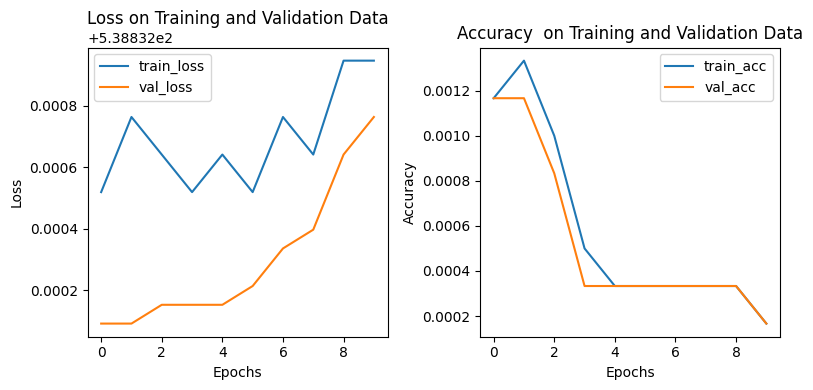

In [ ]:
from matplotlib import pyplot as plt

# the function plot loss and acc
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()

training_vis(hist)